In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [2]:
# Read in the csv containing the contest data and modelled player 3 point make data from the previous stage
df_all = pd.read_csv('CleanedData.csv', index_col=0)
df_all.head()

,Season,ThreePointers,ThreePointersAttempted,ThreePointersMissed,ThreePointersMadePct
Name,,,,,
A.J. Hammons,2017.0,5,10,5,0.500000
A.J. Lawson,2023.0,10,25,15,0.400000
A.J. Lawson,2024.0,12,36,24,0.333333
A.J. Price,2010.0,60,174,114,0.344828
A.J. Price,2011.0,48,165,117,0.290909


In [3]:
# historical 3 point contest results
df_historical = pd.read_csv('3PtHistoricalResults.csv')

# fill NA with 0s
df_historical = df_historical.fillna(0)
df_historical.head()

,name,made,att,dewmade,dewatt
0,Seth Curry,13,25,0.0,0.0
1,Stephen Curry,173,225,3.0,4.0
2,Buddy Hield,91,125,0.0,8.0
3,Damian Lillard,45,75,3.0,4.0
4,Kyle Korver,14,25,0.0,0.0


In [4]:
# Generate a player's 'ability' to make a 3 pointer

df = df_all.copy()
players = df.index.unique()

player_ability_dict = {
    "Player": [],
    "Avg_Weighted": [],
    "Avg_Not_Weighted": []
}

for player in players:
    df_player = df.loc[df.index == player]
    player_ability_dict['Player'].append(player)
    
    num_seasons = len(df_player['Season'].unique())
    max_season = 4 if num_seasons > 4 else num_seasons

    # weighted average, linear weighting, take the last maximum 4 years.
    weights_straight = np.arange(1, max_season + 1)
    three_pointers = df_player[-max_season:]['ThreePointersMadePct']

    weighted_avg = np.average(np.array(three_pointers), weights=weights_straight)
    player_ability_dict['Avg_Weighted'].append(weighted_avg)

    # no weight, everything equal
    no_weight_avg = np.average(np.array(df_player['ThreePointersMadePct']))
    player_ability_dict['Avg_Not_Weighted'].append(no_weight_avg)
    
pd.DataFrame.from_dict(player_ability_dict)

,Player,Avg_Weighted,Avg_Not_Weighted
0,A.J. Hammons,0.500000,0.500000
1,A.J. Lawson,0.355556,0.366667
2,A.J. Price,0.286627,0.302846
3,AJ Green,0.401978,0.406245
4,AJ Griffin,0.311805,0.331344
...,...,...,...
1956,Zion Williamson,0.372207,0.372778
1957,Zoran Dragic,0.214286,0.214286
1958,Zoran Planinic,0.286526,0.293290
1959,Zydrunas Ilgauskas,0.208863,0.172077


In [5]:
df_reset = df_all.reset_index()

# Getting just their 2024 make percentage
df_2024 = df_reset.loc[df_reset['Season'] == 2024][['Name', 'ThreePointersMadePct']]
df_2024 = df_2024.rename(columns={'Name': 'Player', 'ThreePointersMadePct': '2024_Avg_Pct'})

df_ability = pd.DataFrame.from_dict(player_ability_dict)
df_ability = pd.merge(df_ability, df_2024)

# this is each player's global ability, so their 3 point make % in the NBA generally using 3 different metrics
df_ability

# notice we've lost almost 1500 rows because not every player that we had in the previous table was active in 2024

,Player,Avg_Weighted,Avg_Not_Weighted,2024_Avg_Pct
0,A.J. Lawson,0.355556,0.366667,0.333333
1,AJ Green,0.401978,0.406245,0.393443
2,AJ Griffin,0.311805,0.331344,0.272727
3,Aaron Gordon,0.323808,0.317033,0.293333
4,Aaron Holiday,0.401642,0.385910,0.406504
...,...,...,...,...
498,Zach Collins,0.333136,0.334826,0.290323
499,Zach LaVine,0.371829,0.374655,0.349112
500,Zeke Nnaji,0.339148,0.363858,0.312500
501,Ziaire Williams,0.295876,0.295684,0.314103


In [6]:
# Each player's actual 3 point make % from historical 3 point contest data
df_historical['Actual'] = df_historical['made'] / df_historical['att']
df_historical['dewActual'] = df_historical['dewmade'] / df_historical['dewatt']
df_historical = df_historical.fillna(0)
df_historical.head()

,name,made,att,dewmade,dewatt,Actual,dewActual
0,Seth Curry,13,25,0.0,0.0,0.520000,0.00
1,Stephen Curry,173,225,3.0,4.0,0.768889,0.75
2,Buddy Hield,91,125,0.0,8.0,0.728000,0.00
3,Damian Lillard,45,75,3.0,4.0,0.600000,0.75
4,Kyle Korver,14,25,0.0,0.0,0.560000,0.00


In [7]:
# Model each player's 3 point make ability specifically in the 3 point contest

# let's use the weighted average
df_global_ability = df_ability[['Player', 'Avg_Weighted']]
df_global_ability = df_global_ability.rename(columns={'Avg_Weighted': 'Make3Perc'})

# only take the global abilities from players who have played in the 3 point contest previously
df_global_players = df_global_ability[df_global_ability['Player'].isin(df_historical['name'].tolist())]
df_global_players = df_global_players.fillna(0)

print(df_global_players.shape)
print(df_historical.shape)

# there are 5 players who have played in the 3 point contest who we don't seem to have any data for 
no_data_players = [p for p in df_historical['name'].tolist() if p not in df_global_players['Player'].tolist()]
print(no_data_players)

# none of these players are ones who are competing in the upcoming 3 point contest so we can ignore
df_historical = df_historical[~df_historical['name'].isin(no_data_players)]
df_global_players = df_global_players[~df_global_players['Player'].isin(no_data_players)]

print(df_global_players.shape)
print(df_historical.shape)

(38, 2)
(43, 7)
['Kyle Korver', 'J.J. Redick', 'Dirk Nowitzki', 'Kemba Walker', 'Marco Belinelli']
(38, 2)
(38, 7)


In [8]:
# order the two tables so that the names are in the same order
df_global_players = df_global_players.reset_index()
df_historical = df_historical.sort_values('name').reset_index()

print(df_global_players.head())
print(df_historical.head())

   index          Player  Make3Perc
0     43    Bradley Beal   0.347381
1     55     Buddy Hield   0.393311
2     56   C.J. McCollum   0.408477
3     98  Damian Lillard   0.353682
4    101     Danny Green   0.241922
   index            name  made  att  dewmade  dewatt  Actual  dewActual
0     39    Bradley Beal    15   25      0.0     0.0   0.600       0.00
1      2     Buddy Hield    91  125      0.0     8.0   0.728       0.00
2     17   C.J. McCollum    24   50      0.0     0.0   0.480       0.00
3      3  Damian Lillard    45   75      3.0     4.0   0.600       0.75
4     22     Danny Green    16   25      0.0     0.0   0.640       0.00


In [9]:
# Merge the two dataframes into one and rename the columns for better readability
df_contest_merged = pd.merge(df_global_players, df_historical, left_on='Player', right_on='name')[['Player', 'Make3Perc', 'made', 'att', 'dewmade', 'dewatt', 'Actual', 'dewActual']]
df_contest_merged = df_contest_merged.rename(columns={'Make3Perc': 'GlobalMake', 'Actual': 'ContestMakeActual', 'dewActual': 'dewContestMakeActual'})
df_contest_merged.head()

,Player,GlobalMake,made,att,dewmade,dewatt,ContestMakeActual,dewContestMakeActual
0,Bradley Beal,0.347381,15,25,0.0,0.0,0.600,0.00
1,Buddy Hield,0.393311,91,125,0.0,8.0,0.728,0.00
2,C.J. McCollum,0.408477,24,50,0.0,0.0,0.480,0.00
3,Damian Lillard,0.353682,45,75,3.0,4.0,0.600,0.75
4,Danny Green,0.241922,16,25,0.0,0.0,0.640,0.00


In [10]:
# need to just give the glm non zero data otherwise it will error on the fit
df_non_zero = df_contest_merged[df_contest_merged['att'] != 0]

# A formula expression of the form y ~ model is interpreted as the response y is modelled by a linear predictor specified symbolically by model.
# We're essentially trying to predict the ContestMakeActual given the GlobalMake and giving the previous historical 3 point contest
# attempts as weights. We use a binomial because a shot is either in or not.
glm_3pt_contest = smf.glm('ContestMakeActual ~ GlobalMake', data=df_non_zero, freq_weights=df_non_zero['att'], family=sm.families.Binomial())

res = glm_3pt_contest.fit()
print(res.summary())

print("Coefficeients")
print(res.params)
print("p-Values")
print(res.pvalues)
print("Dependent variables")
print(res.model.endog_names)

predicted = res.predict(df_contest_merged)
df_contest_merged['ProjectedMake'] = predicted
df_contest_merged.head()

                 Generalized Linear Model Regression Results                  
Dep. Variable:      ContestMakeActual   No. Observations:                   35
Model:                            GLM   Df Residuals:                     1923
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -861.75
Date:                Fri, 09 Feb 2024   Deviance:                       92.077
Time:                        10:38:11   Pearson chi2:                     91.6
No. Iterations:                     3   Pseudo R-squ. (CS):             0.2948
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.6210      0.595     -2.726      0.0

,Player,GlobalMake,made,att,dewmade,dewatt,ContestMakeActual,dewContestMakeActual,ProjectedMake
0,Bradley Beal,0.347381,15,25,0.0,0.0,0.600,0.00,0.563809
1,Buddy Hield,0.393311,91,125,0.0,8.0,0.728,0.00,0.623608
2,C.J. McCollum,0.408477,24,50,0.0,0.0,0.480,0.00,0.642646
3,Damian Lillard,0.353682,45,75,3.0,4.0,0.600,0.75,0.572167
4,Danny Green,0.241922,16,25,0.0,0.0,0.640,0.00,0.422291


In [11]:
# do the same for the dew balls
df_non_zero = df_contest_merged[df_contest_merged['dewatt'] != 0]

glm_dewball = smf.glm('dewContestMakeActual ~ GlobalMake', data=df_non_zero, freq_weights=df_non_zero['dewatt'], family=sm.families.Binomial())

res_dew = glm_dewball.fit()
print(res_dew.summary())

print("Coefficeients")
print(res_dew.params)
print("p-Values")
print(res_dew.pvalues)
print("Dependent variables")
print(res_dew.model.endog_names)

predicted_dew = res_dew.predict(df_contest_merged)

df_contest_merged['DewProjectedMake'] = predicted_dew
df_contest_merged.head()

                  Generalized Linear Model Regression Results                   
Dep. Variable:     dewContestMakeActual   No. Observations:                   24
Model:                              GLM   Df Residuals:                       80
Model Family:                  Binomial   Df Model:                            1
Link Function:                    Logit   Scale:                          1.0000
Method:                            IRLS   Log-Likelihood:                -40.766
Date:                  Fri, 09 Feb 2024   Deviance:                       35.141
Time:                          10:38:13   Pearson chi2:                     27.8
No. Iterations:                       4   Pseudo R-squ. (CS):           0.006344
Covariance Type:              nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.9725      3.375

,Player,GlobalMake,made,att,dewmade,dewatt,ContestMakeActual,dewContestMakeActual,ProjectedMake,DewProjectedMake
0,Bradley Beal,0.347381,15,25,0.0,0.0,0.600,0.00,0.563809,0.313670
1,Buddy Hield,0.393311,91,125,0.0,8.0,0.728,0.00,0.623608,0.348474
2,C.J. McCollum,0.408477,24,50,0.0,0.0,0.480,0.00,0.642646,0.360355
3,Damian Lillard,0.353682,45,75,3.0,4.0,0.600,0.75,0.572167,0.318333
4,Danny Green,0.241922,16,25,0.0,0.0,0.640,0.00,0.422291,0.241567


In [12]:
# Let's look at the results of the fit.
# Fit for dewContestMakePred does not look good, but most likely this is due to lack of data
df_contest_merged

,Player,GlobalMake,made,att,dewmade,dewatt,ContestMakeActual,dewContestMakeActual,ProjectedMake,DewProjectedMake
0,Bradley Beal,0.347381,15,25,0.0,0.0,0.600000,0.000000,0.563809,0.313670
1,Buddy Hield,0.393311,91,125,0.0,8.0,0.728000,0.000000,0.623608,0.348474
2,C.J. McCollum,0.408477,24,50,0.0,0.0,0.480000,0.000000,0.642646,0.360355
3,Damian Lillard,0.353682,45,75,3.0,4.0,0.600000,0.750000,0.572167,0.318333
4,Danny Green,0.241922,16,25,0.0,0.0,0.640000,0.000000,0.422291,0.241567
5,Davis Bertans,0.390593,29,50,2.0,4.0,0.580000,0.500000,0.620154,0.346364
6,Desmond Bane,0.404546,12,25,1.0,2.0,0.480000,0.500000,0.637751,0.357258
7,Devin Booker,0.379734,108,175,3.0,4.0,0.617143,0.750000,0.606234,0.337995
8,Devonte' Graham,0.350730,10,25,1.0,2.0,0.400000,0.500000,0.568256,0.316144
9,Donovan Mitchell,0.361934,17,25,0.0,2.0,0.680000,0.000000,0.583048,0.324496


C:\Users\SereneChongtrakul\AppData\Local\Temp\ipykernel_12752\1185136784.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(df_contest_merged['Player'], rotation = 75)
C:\Users\SereneChongtrakul\AppData\Local\Temp\ipykernel_12752\1185136784.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(df_contest_merged['Player'], rotation = 75)


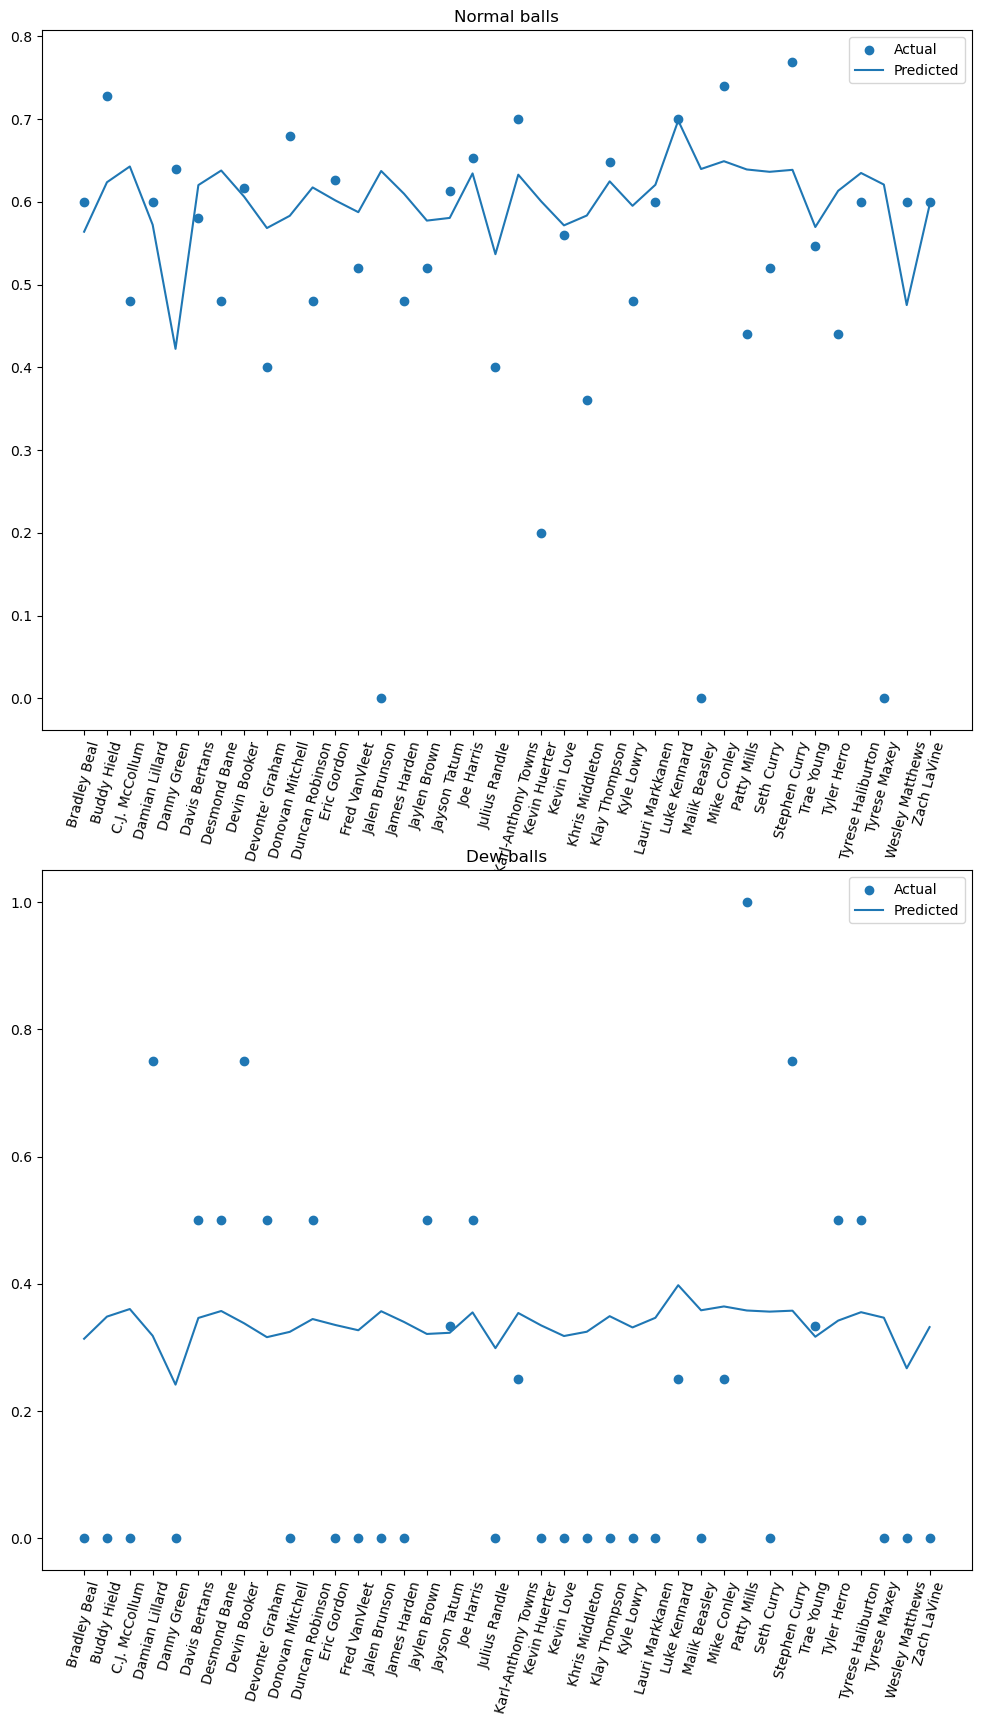

In [13]:
fig, ax = plt.subplots(2, figsize=(12,20))

ax[0].scatter(df_contest_merged['Player'], df_contest_merged['ContestMakeActual'], label='Actual')
ax[0].plot(df_contest_merged['Player'], df_contest_merged['ProjectedMake'], label='Predicted')
ax[0].legend()
ax[0].set_xticklabels(df_contest_merged['Player'], rotation = 75)
ax[0].set_title('Normal balls')

ax[1].scatter(df_contest_merged['Player'], df_contest_merged['dewContestMakeActual'], label='Actual')
ax[1].plot(df_contest_merged['Player'], df_contest_merged['DewProjectedMake'], label='Predicted')
ax[1].legend()
ax[1].set_xticklabels(df_contest_merged['Player'], rotation = 75)
ax[1].set_title('Dew balls')

plt.show()

In [ ]:
df_contest_merged.to_csv('ModelledData.csv')